TOP 10 FEATURES 🏆

XGBoost Evaluation Metrics (Alagnak, Top 10 Features):
R²   (R-squared):              -0.5278
MSE  (Mean Squared Error):     5324529037171.48
MAPE (Mean Absolute % Error):  35.78%

Random Forest + Log-Transformed Target + GridSearchCV (Alagnak, Top 10 Features):
Best Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
R²   (R-squared):              -0.2206
MSE  (Mean Squared Error):     4253974674981.10
MAPE (Mean Absolute % Error):  35.19%

Random Forest with Log-Transformed Target (Alagnak, Top 10 Features):
R²   (R-squared):              -0.1743
MSE  (Mean Squared Error):     4092706095082.66
MAPE (Mean Absolute % Error):  35.87%

Random Forest Evaluation Metrics (Alagnak, Top 10 Features): 🏆
R²   (R-squared):              0.0283
MSE  (Mean Squared Error):     3386374415202.25
MAPE (Mean Absolute % Error):  35.77%

Linear Regression Evaluation Metrics (Alagnak, Top 10 Features):
R²   (R-squared):              -0.1972
MSE  (Mean Squared Error):     4172539658250.78
MAPE (Mean Absolute % Error):  34.19%

Polynomial Regression Evaluation Metrics (Alagnak, Top 7 Features):
R²   (R-squared):              -11.0061
MSE  (Mean Squared Error):     41842410997153.58
MAPE (Mean Absolute % Error):  101.14%

Gradient Boosting Evaluation Metrics (Alagnak, Top 10 Features):
R²   (R-squared):              -0.4140
MSE  (Mean Squared Error):     4927932252224.54
MAPE (Mean Absolute % Error):  38.63%


GradientBoostingRegressor

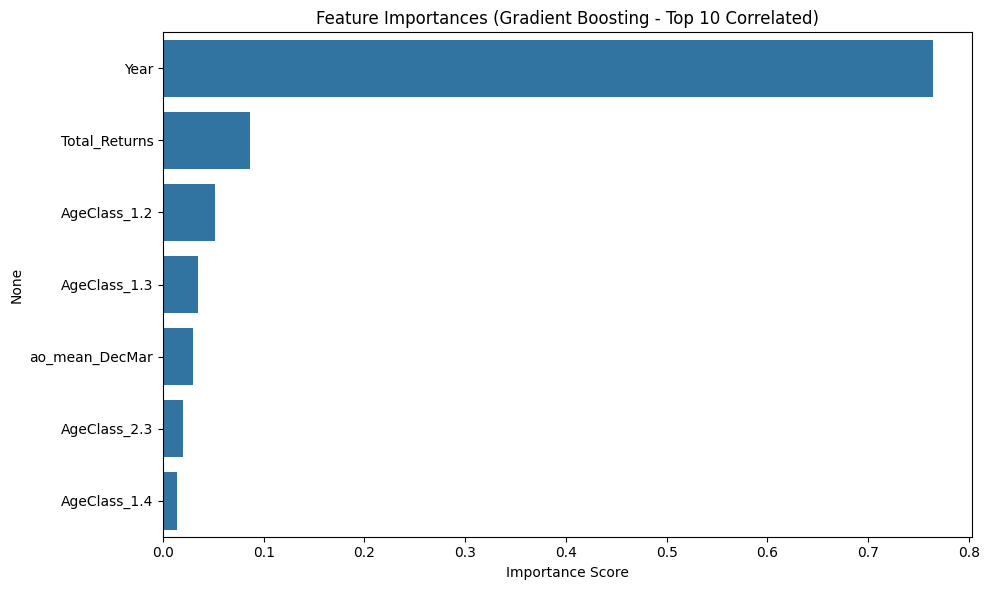

Gradient Boosting Evaluation Metrics (Alagnak, Top 10 Features):
R²   (R-squared):              -0.4140
MSE  (Mean Squared Error):     4927932252224.54
MAPE (Mean Absolute % Error):  38.63%


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# === Step 1: Load and filter data ===
data_set_bristol = pd.read_csv(
    r'C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\THIRD_APPROACH\data_set_bristol_encoded.csv'
)

# Keep only rows where River is 'Alagnak'
df_alagnak = data_set_bristol[data_set_bristol['River'] == 'Alagnak'].copy()

# === Step 2: Select top 10 features most correlated with the target ===
correlation = df_alagnak.corr(numeric_only=True)
target_corr = correlation['Total_Returns_NextYear'].drop('Total_Returns_NextYear')
top10_features = target_corr.abs().sort_values(ascending=False).head(7).index.tolist()

# Ensure no duplicate columns and keep what's needed
columns_to_keep = top10_features + ['Total_Returns_NextYear', 'River']
if 'Year' not in top10_features:
    columns_to_keep.append('Year')

df_alagnak = df_alagnak[columns_to_keep]

# === Step 3: Define and apply time-based split ===
def split_time_series_by_river(df, time_column, group_columns, test_fraction=0.2, gap_years=0):
    data_train = pd.DataFrame()
    data_test = pd.DataFrame()

    for _, group_df in df.groupby(group_columns):
        group_df = group_df.sort_values(by=time_column)
        split_idx = int(len(group_df) * (1 - test_fraction))
        train_split = group_df.iloc[:split_idx - gap_years]
        test_split = group_df.iloc[split_idx:]
        data_train = pd.concat([data_train, train_split], axis=0)
        data_test = pd.concat([data_test, test_split], axis=0)

    return data_train.reset_index(drop=True), data_test.reset_index(drop=True)

data_train, data_test = split_time_series_by_river(
    df_alagnak,
    time_column="Year",
    group_columns=["River"],
    test_fraction=0.2,
    gap_years=0
)

# === Step 4: Prepare features and target ===
drop_columns = ['Total_Returns_NextYear', 'River']
if 'Year' not in top10_features:
    drop_columns.append('Year')

X_train = data_train.drop(drop_columns, axis=1)
y_train = data_train['Total_Returns_NextYear']

X_test = data_test.drop(drop_columns, axis=1)
y_test = data_test['Total_Returns_NextYear']

# === Step 5: Train Gradient Boosting Regressor ===
gbr = GradientBoostingRegressor(
    n_estimators=200, 
    learning_rate=0.05, 
    max_depth=4, 
    random_state=42
)
gbr.fit(X_train, y_train)

# === Step 6: Feature Importances Plot ===
feature_importances = pd.Series(gbr.feature_importances_, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Feature Importances (Gradient Boosting - Top 10 Correlated)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# === Step 7: Predict & Evaluate ===
y_pred = gbr.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("Gradient Boosting Evaluation Metrics (Alagnak, Top 10 Features):")
print(f"R²   (R-squared):              {r2:.4f}")
print(f"MSE  (Mean Squared Error):     {mse:.2f}")
print(f"MAPE (Mean Absolute % Error):  {mape:.2f}%")


Polynomial Regression

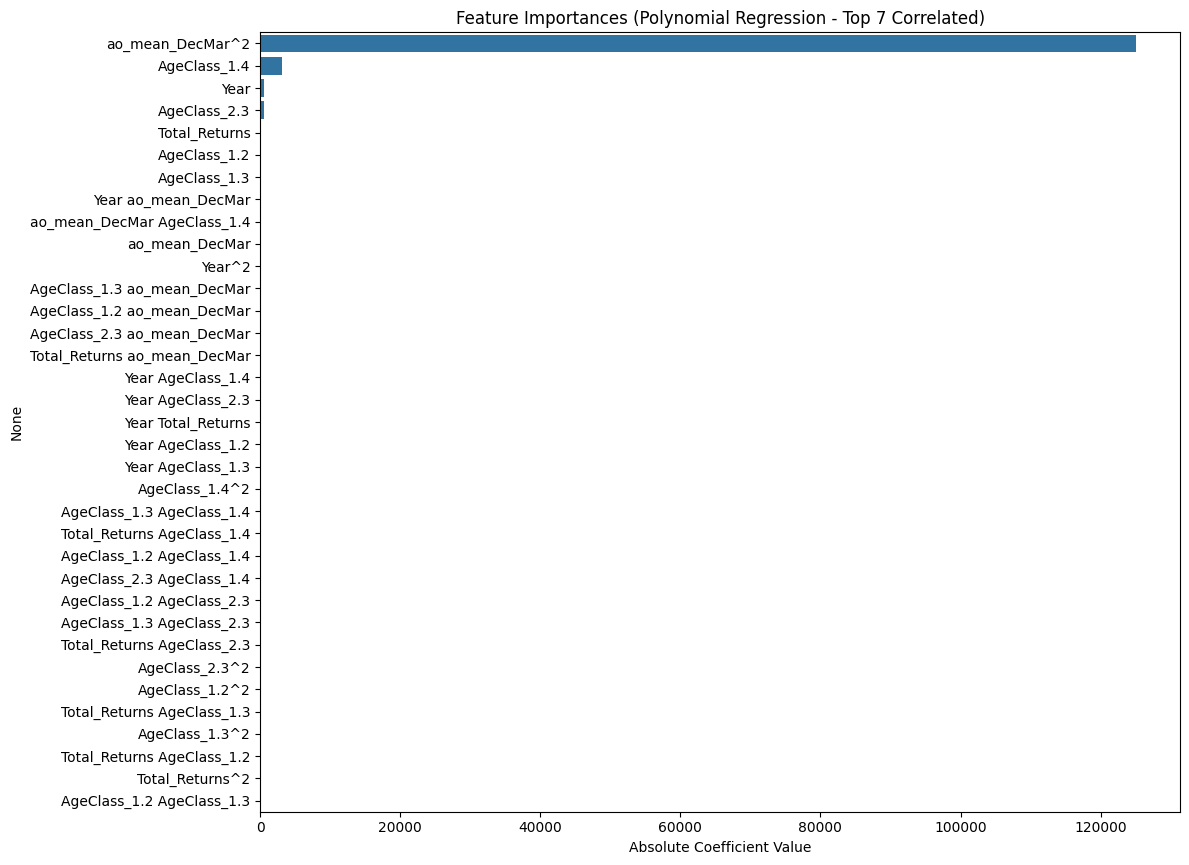

Polynomial Regression Evaluation Metrics (Alagnak, Top 7 Features):
R²   (R-squared):              -11.0061
MSE  (Mean Squared Error):     41842410997153.58
MAPE (Mean Absolute % Error):  101.14%


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# === Step 1: Load and filter data ===
data_set_bristol = pd.read_csv(
    r'C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\THIRD_APPROACH\data_set_bristol_encoded.csv'
)

# Keep only rows where River is 'Alagnak'
df_alagnak = data_set_bristol[data_set_bristol['River'] == 'Alagnak'].copy()

# === Step 2: Select top 7 features most correlated with the target ===
correlation = df_alagnak.corr(numeric_only=True)
target_corr = correlation['Total_Returns_NextYear'].drop('Total_Returns_NextYear')
top10_features = target_corr.abs().sort_values(ascending=False).head(7).index.tolist()

# Ensure no duplicate 'Year' column
columns_to_keep = top10_features + ['Total_Returns_NextYear', 'River']
if 'Year' not in top10_features:
    columns_to_keep.append('Year')

df_alagnak = df_alagnak[columns_to_keep]

# === Step 3: Define and apply time-series split ===
def split_time_series_by_river(df, time_column, group_columns, test_fraction=0.2, gap_years=0):
    data_train = pd.DataFrame()
    data_test = pd.DataFrame()

    for _, group_df in df.groupby(group_columns):
        group_df = group_df.sort_values(by=time_column)
        split_idx = int(len(group_df) * (1 - test_fraction))
        train_split = group_df.iloc[:split_idx - gap_years]
        test_split = group_df.iloc[split_idx:]
        data_train = pd.concat([data_train, train_split], axis=0)
        data_test = pd.concat([data_test, test_split], axis=0)

    return data_train.reset_index(drop=True), data_test.reset_index(drop=True)

data_train, data_test = split_time_series_by_river(
    df_alagnak,
    time_column="Year",
    group_columns=["River"],
    test_fraction=0.2,
    gap_years=0
)

# === Step 4: Prepare features and target ===
drop_columns = ['Total_Returns_NextYear', 'River']
if 'Year' not in top10_features:
    drop_columns.append('Year')

X_train = data_train.drop(drop_columns, axis=1)
y_train = data_train['Total_Returns_NextYear']

X_test = data_test.drop(drop_columns, axis=1)
y_test = data_test['Total_Returns_NextYear']

# === Step 5: Polynomial Features + Linear Regression ===
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

feature_names = poly.get_feature_names_out(X_train.columns)

model = LinearRegression()
model.fit(X_train_poly, y_train)

# === Step 6: Plot Coefficients (All Features) ===
coefficients = pd.Series(model.coef_, index=feature_names)
top_features = coefficients.abs().sort_values(ascending=False)

plt.figure(figsize=(12, max(6, len(top_features) * 0.25)))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Feature Importances (Polynomial Regression - Top 7 Correlated)")
plt.xlabel("Absolute Coefficient Value")
plt.tight_layout()
plt.show()

# === Step 7: Predict & Evaluate ===
y_pred = model.predict(X_test_poly)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("Polynomial Regression Evaluation Metrics (Alagnak, Top 7 Features):")
print(f"R²   (R-squared):              {r2:.4f}")
print(f"MSE  (Mean Squared Error):     {mse:.2f}")
print(f"MAPE (Mean Absolute % Error):  {mape:.2f}%")


Linear Regression

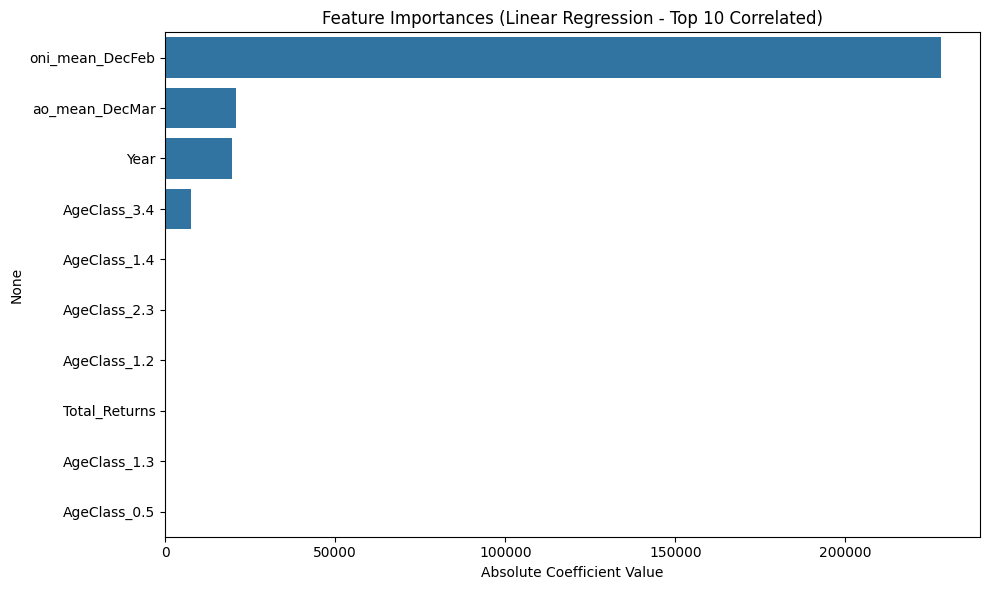

Linear Regression Evaluation Metrics (Alagnak, Top 10 Features):
R²   (R-squared):              -0.1972
MSE  (Mean Squared Error):     4172539658250.78
MAPE (Mean Absolute % Error):  34.19%


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# === Step 1: Load and filter data ===
data_set_bristol = pd.read_csv(
    r'C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\THIRD_APPROACH\data_set_bristol_encoded.csv'
)

# Keep only rows where River is 'Alagnak'
df_alagnak = data_set_bristol[data_set_bristol['River'] == 'Alagnak'].copy()

# === Step 2: Select top 10 features most correlated with the target ===
correlation = df_alagnak.corr(numeric_only=True)
target_corr = correlation['Total_Returns_NextYear'].drop('Total_Returns_NextYear')
top10_features = target_corr.abs().sort_values(ascending=False).head(10).index.tolist()

# Ensure no duplicate 'Year' column
columns_to_keep = top10_features + ['Total_Returns_NextYear', 'River']
if 'Year' not in top10_features:
    columns_to_keep.append('Year')

df_alagnak = df_alagnak[columns_to_keep]

# === Step 3: Define and apply time-series split ===
def split_time_series_by_river(df, time_column, group_columns, test_fraction=0.2, gap_years=0):
    data_train = pd.DataFrame()
    data_test = pd.DataFrame()

    for _, group_df in df.groupby(group_columns):
        group_df = group_df.sort_values(by=time_column)
        split_idx = int(len(group_df) * (1 - test_fraction))
        train_split = group_df.iloc[:split_idx - gap_years]
        test_split = group_df.iloc[split_idx:]
        data_train = pd.concat([data_train, train_split], axis=0)
        data_test = pd.concat([data_test, test_split], axis=0)

    return data_train.reset_index(drop=True), data_test.reset_index(drop=True)

data_train, data_test = split_time_series_by_river(
    df_alagnak,
    time_column="Year",
    group_columns=["River"],
    test_fraction=0.2,
    gap_years=0
)

# === Step 4: Prepare features and target ===
drop_columns = ['Total_Returns_NextYear', 'River']
if 'Year' not in top10_features:
    drop_columns.append('Year')

X_train = data_train.drop(drop_columns, axis=1)
y_train = data_train['Total_Returns_NextYear']

X_test = data_test.drop(drop_columns, axis=1)
y_test = data_test['Total_Returns_NextYear']

# === Step 5: Train Linear Regression ===
model = LinearRegression()
model.fit(X_train, y_train)

# === Step 6: Plot Coefficients ===
coefficients = pd.Series(model.coef_, index=X_train.columns)
top_features = coefficients.abs().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Feature Importances (Linear Regression - Top 10 Correlated)")
plt.xlabel("Absolute Coefficient Value")
plt.tight_layout()
plt.show()

# === Step 7: Predict & Evaluate ===
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("Linear Regression Evaluation Metrics (Alagnak, Top 10 Features):")
print(f"R²   (R-squared):              {r2:.4f}")
print(f"MSE  (Mean Squared Error):     {mse:.2f}")
print(f"MAPE (Mean Absolute % Error):  {mape:.2f}%")


Random Forest model

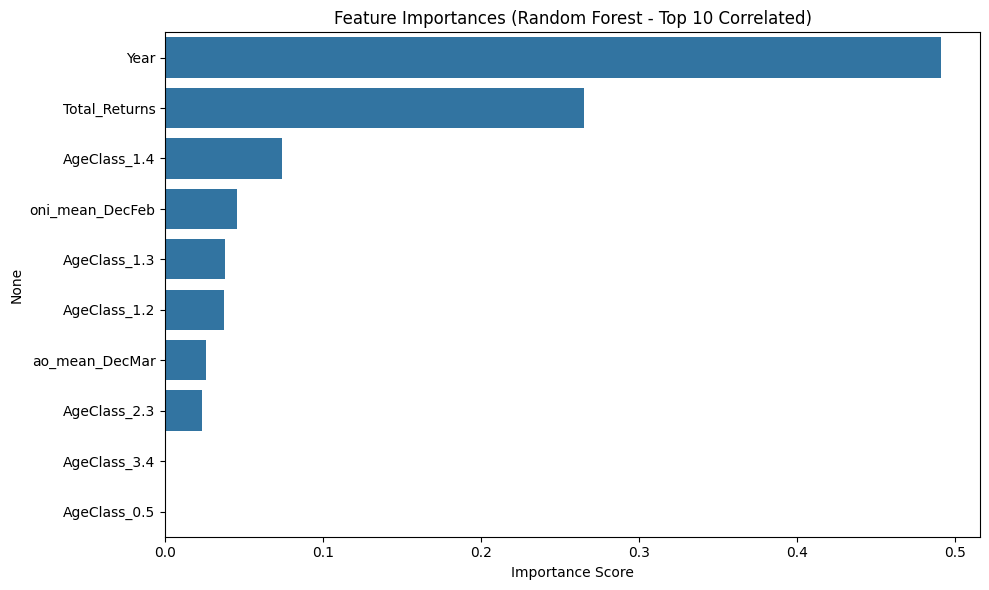

Random Forest Evaluation Metrics (Alagnak, Top 10 Features):
R²   (R-squared):              0.0283
MSE  (Mean Squared Error):     3386374415202.25
MAPE (Mean Absolute % Error):  35.77%


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# === Step 1: Load and filter data ===
data_set_bristol = pd.read_csv(
    r'C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\THIRD_APPROACH\data_set_bristol_encoded.csv'
)

# Keep only rows where River is 'Alagnak'
df_alagnak = data_set_bristol[data_set_bristol['River'] == 'Alagnak'].copy()

# === Step 2: Select top 10 features most correlated with the target ===
correlation = df_alagnak.corr(numeric_only=True)
target_corr = correlation['Total_Returns_NextYear'].drop('Total_Returns_NextYear')
top10_features = target_corr.abs().sort_values(ascending=False).head(10).index.tolist()

# Ensure no duplicate 'Year' column
columns_to_keep = top10_features + ['Total_Returns_NextYear', 'River']
if 'Year' not in top10_features:
    columns_to_keep.append('Year')

df_alagnak = df_alagnak[columns_to_keep]

# === Step 3: Define and apply time-series split ===
def split_time_series_by_river(df, time_column, group_columns, test_fraction=0.2, gap_years=0):
    data_train = pd.DataFrame()
    data_test = pd.DataFrame()

    for _, group_df in df.groupby(group_columns):
        group_df = group_df.sort_values(by=time_column)
        split_idx = int(len(group_df) * (1 - test_fraction))
        train_split = group_df.iloc[:split_idx - gap_years]
        test_split = group_df.iloc[split_idx:]
        data_train = pd.concat([data_train, train_split], axis=0)
        data_test = pd.concat([data_test, test_split], axis=0)

    return data_train.reset_index(drop=True), data_test.reset_index(drop=True)

data_train, data_test = split_time_series_by_river(
    df_alagnak,
    time_column="Year",
    group_columns=["River"],
    test_fraction=0.2,
    gap_years=0
)

# === Step 4: Prepare features and target ===
drop_columns = ['Total_Returns_NextYear', 'River']
if 'Year' not in top10_features:
    drop_columns.append('Year')

X_train = data_train.drop(drop_columns, axis=1)
y_train = data_train['Total_Returns_NextYear']

X_test = data_test.drop(drop_columns, axis=1)
y_test = data_test['Total_Returns_NextYear']

# === Step 5: Train Random Forest Regressor ===
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42
)
rf.fit(X_train, y_train)

# === Step 6: Feature Importances Plot ===
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Feature Importances (Random Forest - Top 10 Correlated)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# === Step 7: Predict & Evaluate ===
y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("Random Forest Evaluation Metrics (Alagnak, Top 10 Features):")
print(f"R²   (R-squared):              {r2:.4f}")
print(f"MSE  (Mean Squared Error):     {mse:.2f}")
print(f"MAPE (Mean Absolute % Error):  {mape:.2f}%")


Using the best model to predict 2023:

In [3]:
data_set_bristol['River'].unique()

array(['Alagnak', 'Egegik', 'Igushik', 'Kvichak', 'Naknek', 'Nushagak',
       'Ugashik', 'Wood'], dtype=object)

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# === Step 1: Load and filter data ===
data_set_bristol = pd.read_csv(
    r'C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\THIRD_APPROACH\data_set_bristol_encoded.csv'
)

# Filter only for River = 'Alagnak'
df_alagnak = data_set_bristol[data_set_bristol['River'] == 'Alagnak'].copy()

# === Step 2: Select top 10 correlated features with the target ===
correlation = df_alagnak.corr(numeric_only=True)
target_corr = correlation['Total_Returns_NextYear'].drop('Total_Returns_NextYear')
top10_features = target_corr.abs().sort_values(ascending=False).head(10).index.tolist()

# Keep top features + target + River + Year (if not already)
columns_to_keep = top10_features + ['Total_Returns_NextYear', 'River']
if 'Year' not in top10_features:
    columns_to_keep.append('Year')
df_alagnak = df_alagnak[columns_to_keep]

# === Step 3: Split training (<=2022) and test (2023) ===
train_data = df_alagnak[df_alagnak['Year'] <= 2022].copy()
predict_data = df_alagnak[df_alagnak['Year'] == 2023].copy()

# Drop unneeded columns
drop_cols = ['Total_Returns_NextYear', 'River']
if 'Year' not in top10_features:
    drop_cols.append('Year')

X_train = train_data.drop(columns=drop_cols)
y_train = train_data['Total_Returns_NextYear']

X_2023 = predict_data.drop(columns=drop_cols)

# === Step 4: Train Random Forest ===
rf = RandomForestRegressor(n_estimators=200, max_depth=None, random_state=42)
rf.fit(X_train, y_train)

# === Step 5: Predict 2023 ===
y_2023_pred = rf.predict(X_2023)

print(f"✅ Prediction for Total_Returns_NextYear in 2023 (Alagnak): {y_2023_pred[0]:,.0f}")

# Optional: Compare with actual
if not predict_data['Total_Returns_NextYear'].isnull().values[0]:
    actual_2023 = predict_data['Total_Returns_NextYear'].values[0]
    print(f"📌 Actual value: {actual_2023:,.0f}")
    error = abs(y_2023_pred[0] - actual_2023)
    print(f"📉 Absolute Error: {error:,.0f}")


✅ Prediction for Total_Returns_NextYear in 2023 (Alagnak): 2,776,207
📌 Actual value: 4,335,435
📉 Absolute Error: 1,559,228


this was the best model so ill do something different here test all features removing one by one

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# === Step 1: Load and filter data ===
data_set_bristol = pd.read_csv(
    r'C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\THIRD_APPROACH\data_set_bristol_encoded.csv'
)

# Keep only rows where River is 'Alagnak'
df_alagnak = data_set_bristol[data_set_bristol['River'] == 'Alagnak'].copy()

# === Step 2: Get all features except target and River (keep Year!)
all_features = df_alagnak.drop(['Total_Returns_NextYear', 'River'], axis=1).columns.tolist()

# Keep only necessary columns
columns_to_keep = all_features + ['Total_Returns_NextYear', 'River']
df_alagnak = df_alagnak[columns_to_keep]

# === Step 3: Time-series split function ===
def split_time_series_by_river(df, time_column, group_columns, test_fraction=0.2, gap_years=0):
    data_train = pd.DataFrame()
    data_test = pd.DataFrame()
    for _, group_df in df.groupby(group_columns):
        group_df = group_df.sort_values(by=time_column)
        split_idx = int(len(group_df) * (1 - test_fraction))
        train_split = group_df.iloc[:split_idx - gap_years]
        test_split = group_df.iloc[split_idx:]
        data_train = pd.concat([data_train, train_split], axis=0)
        data_test = pd.concat([data_test, test_split], axis=0)
    return data_train.reset_index(drop=True), data_test.reset_index(drop=True)

# === Step 4: Split data ===
data_train, data_test = split_time_series_by_river(
    df_alagnak, time_column="Year", group_columns=["River"],
    test_fraction=0.2, gap_years=0
)

# === Step 5: Train and evaluate model, removing one feature at a time ===
for i in range(len(all_features)):
    current_features = all_features[:len(all_features) - i]
    if len(current_features) == 0:
        break

    X_train = data_train[current_features]
    y_train = data_train['Total_Returns_NextYear']

    X_test = data_test[current_features]
    y_test = data_test['Total_Returns_NextYear']

    rf = RandomForestRegressor(n_estimators=200, max_depth=None, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    print(f"=== Removed {i} feature(s) - Remaining: {len(current_features)} ===")
    print(f"R²   (R-squared):              {r2:.4f}")
    print(f"MSE  (Mean Squared Error):     {mse:.2f}")
    print(f"MAPE (Mean Absolute % Error):  {mape:.2f}%\n")


=== Removed 0 feature(s) - Remaining: 28 ===
R²   (R-squared):              -0.0160
MSE  (Mean Squared Error):     3540965175389.54
MAPE (Mean Absolute % Error):  41.50%

=== Removed 1 feature(s) - Remaining: 27 ===
R²   (R-squared):              0.0096
MSE  (Mean Squared Error):     3451547796740.79
MAPE (Mean Absolute % Error):  40.30%

=== Removed 2 feature(s) - Remaining: 26 ===
R²   (R-squared):              -0.0271
MSE  (Mean Squared Error):     3579681265803.39
MAPE (Mean Absolute % Error):  41.92%

=== Removed 3 feature(s) - Remaining: 25 ===
R²   (R-squared):              -0.0672
MSE  (Mean Squared Error):     3719451954684.60
MAPE (Mean Absolute % Error):  42.30%

=== Removed 4 feature(s) - Remaining: 24 ===
R²   (R-squared):              -0.0264
MSE  (Mean Squared Error):     3577150519014.27
MAPE (Mean Absolute % Error):  42.71%

=== Removed 5 feature(s) - Remaining: 23 ===
R²   (R-squared):              -0.0355
MSE  (Mean Squared Error):     3608707605369.19
MAPE (Mean Abs

****************************************************************************

Random Forest Updated Code with Log Transform on Target

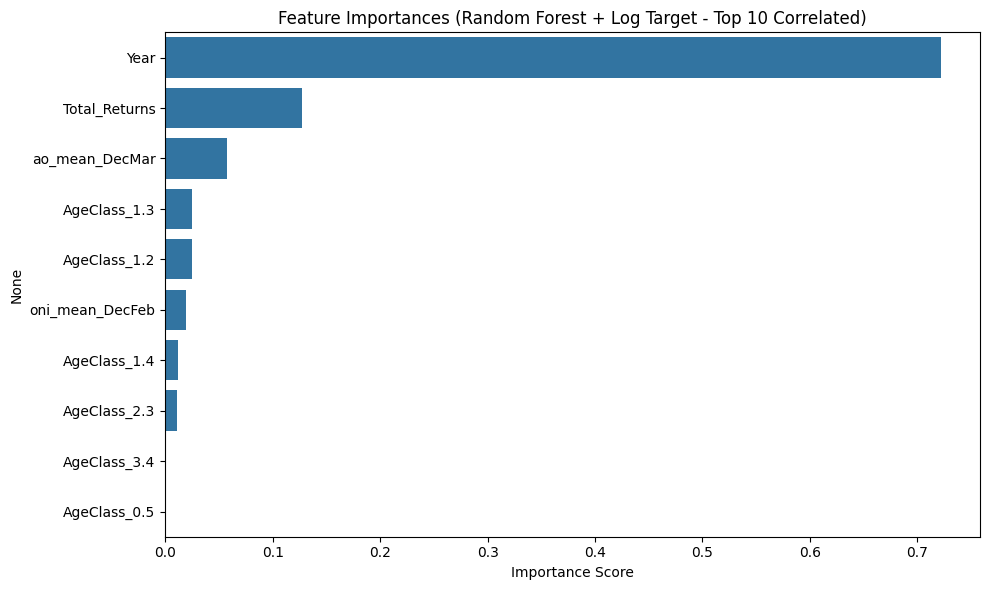

Random Forest with Log-Transformed Target (Alagnak, Top 10 Features):
R²   (R-squared):              -0.1743
MSE  (Mean Squared Error):     4092706095082.66
MAPE (Mean Absolute % Error):  35.87%


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# === Step 1: Load and filter data ===
data_set_bristol = pd.read_csv(
    r'C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\THIRD_APPROACH\data_set_bristol_encoded.csv'
)

# Keep only rows where River is 'Alagnak'
df_alagnak = data_set_bristol[data_set_bristol['River'] == 'Alagnak'].copy()

# === Step 2: Select top 10 features most correlated with the target ===
correlation = df_alagnak.corr(numeric_only=True)
target_corr = correlation['Total_Returns_NextYear'].drop('Total_Returns_NextYear')
top10_features = target_corr.abs().sort_values(ascending=False).head(10).index.tolist()

# Ensure no duplicate 'Year' column
columns_to_keep = top10_features + ['Total_Returns_NextYear', 'River']
if 'Year' not in top10_features:
    columns_to_keep.append('Year')

df_alagnak = df_alagnak[columns_to_keep]

# === Step 3: Define and apply time-series split ===
def split_time_series_by_river(df, time_column, group_columns, test_fraction=0.2, gap_years=0):
    data_train = pd.DataFrame()
    data_test = pd.DataFrame()

    for _, group_df in df.groupby(group_columns):
        group_df = group_df.sort_values(by=time_column)
        split_idx = int(len(group_df) * (1 - test_fraction))
        train_split = group_df.iloc[:split_idx - gap_years]
        test_split = group_df.iloc[split_idx:]
        data_train = pd.concat([data_train, train_split], axis=0)
        data_test = pd.concat([data_test, test_split], axis=0)

    return data_train.reset_index(drop=True), data_test.reset_index(drop=True)

data_train, data_test = split_time_series_by_river(
    df_alagnak,
    time_column="Year",
    group_columns=["River"],
    test_fraction=0.2,
    gap_years=0
)

# === Step 4: Prepare features and log-transformed target ===
drop_columns = ['Total_Returns_NextYear', 'River']
if 'Year' not in top10_features:
    drop_columns.append('Year')

X_train = data_train.drop(drop_columns, axis=1)
y_train_log = np.log1p(data_train['Total_Returns_NextYear'])  # log(1 + y)

X_test = data_test.drop(drop_columns, axis=1)
y_test = data_test['Total_Returns_NextYear']  # real values for evaluation

# === Step 5: Train Random Forest Regressor ===
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42
)
rf.fit(X_train, y_train_log)

# === Step 6: Feature Importances Plot ===
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Feature Importances (Random Forest + Log Target - Top 10 Correlated)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# === Step 7: Predict & Inverse Log Transform ===
y_pred_log = rf.predict(X_test)
y_pred = np.expm1(y_pred_log)  # reverse log1p

# === Step 8: Evaluate ===
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("Random Forest with Log-Transformed Target (Alagnak, Top 10 Features):")
print(f"R²   (R-squared):              {r2:.4f}")
print(f"MSE  (Mean Squared Error):     {mse:.2f}")
print(f"MAPE (Mean Absolute % Error):  {mape:.2f}%")


 Random Forest + Log-Transform + GridSearchCV (Alagnak only):

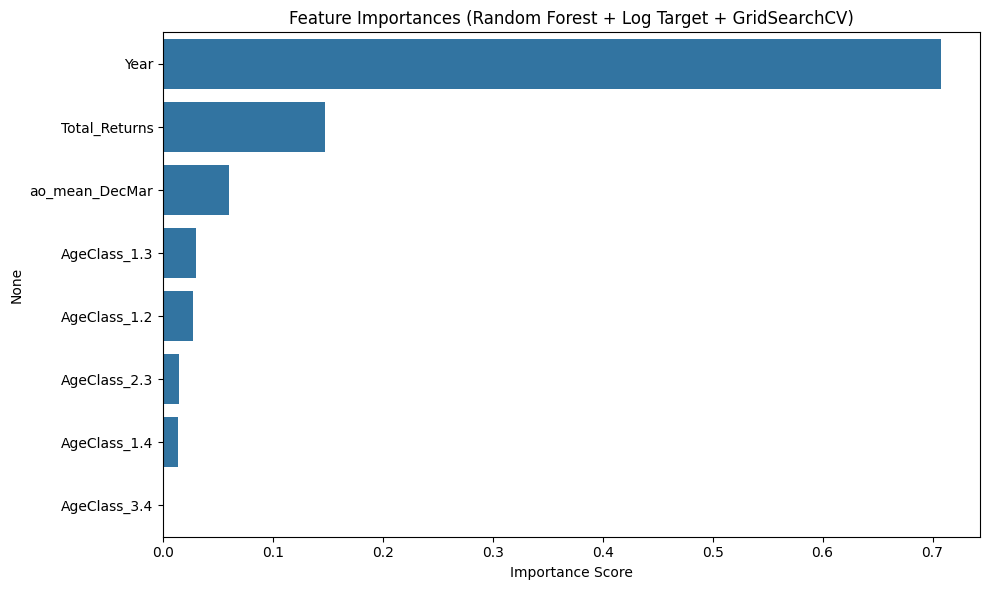

Random Forest + Log-Transformed Target + GridSearchCV (Alagnak, Top 10 Features):
Best Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
R²   (R-squared):              -0.2206
MSE  (Mean Squared Error):     4253974674981.10
MAPE (Mean Absolute % Error):  35.19%


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# === Step 1: Load and filter data ===
data_set_bristol = pd.read_csv(
    r'C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\THIRD_APPROACH\data_set_bristol_encoded.csv'
)

# Keep only rows where River is 'Alagnak'
df_alagnak = data_set_bristol[data_set_bristol['River'] == 'Alagnak'].copy()

# === Step 2: Select top 10 features most correlated with the target ===
correlation = df_alagnak.corr(numeric_only=True)
target_corr = correlation['Total_Returns_NextYear'].drop('Total_Returns_NextYear')
top10_features = target_corr.abs().sort_values(ascending=False).head(8).index.tolist()

# Ensure no duplicate 'Year' column
columns_to_keep = top10_features + ['Total_Returns_NextYear', 'River']
if 'Year' not in top10_features:
    columns_to_keep.append('Year')

df_alagnak = df_alagnak[columns_to_keep]

# === Step 3: Define and apply time-series split ===
def split_time_series_by_river(df, time_column, group_columns, test_fraction=0.2, gap_years=0):
    data_train = pd.DataFrame()
    data_test = pd.DataFrame()

    for _, group_df in df.groupby(group_columns):
        group_df = group_df.sort_values(by=time_column)
        split_idx = int(len(group_df) * (1 - test_fraction))
        train_split = group_df.iloc[:split_idx - gap_years]
        test_split = group_df.iloc[split_idx:]
        data_train = pd.concat([data_train, train_split], axis=0)
        data_test = pd.concat([data_test, test_split], axis=0)

    return data_train.reset_index(drop=True), data_test.reset_index(drop=True)

data_train, data_test = split_time_series_by_river(
    df_alagnak,
    time_column="Year",
    group_columns=["River"],
    test_fraction=0.2,
    gap_years=0
)

# === Step 4: Prepare features and log-transformed target ===
drop_columns = ['Total_Returns_NextYear', 'River']
if 'Year' not in top10_features:
    drop_columns.append('Year')

X_train = data_train.drop(drop_columns, axis=1)
y_train_log = np.log1p(data_train['Total_Returns_NextYear'])  # log(1 + y)

X_test = data_test.drop(drop_columns, axis=1)
y_test = data_test['Total_Returns_NextYear']  # real values for evaluation

# === Step 5: Define GridSearchCV ===
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    scoring='r2',
    cv=3,
    n_jobs=-1
)
grid_search.fit(X_train, y_train_log)

# Best estimator from grid search
best_rf = grid_search.best_estimator_

# === Step 6: Feature Importances Plot ===
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Feature Importances (Random Forest + Log Target + GridSearchCV)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# === Step 7: Predict & Inverse Log Transform ===
y_pred_log = best_rf.predict(X_test)
y_pred = np.expm1(y_pred_log)

# === Step 8: Evaluate ===
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# === Step 9: Report ===
print("Random Forest + Log-Transformed Target + GridSearchCV (Alagnak, Top 10 Features):")
print(f"Best Params: {grid_search.best_params_}")
print(f"R²   (R-squared):              {r2:.4f}")
print(f"MSE  (Mean Squared Error):     {mse:.2f}")
print(f"MAPE (Mean Absolute % Error):  {mape:.2f}%")


XGBoost Regressor

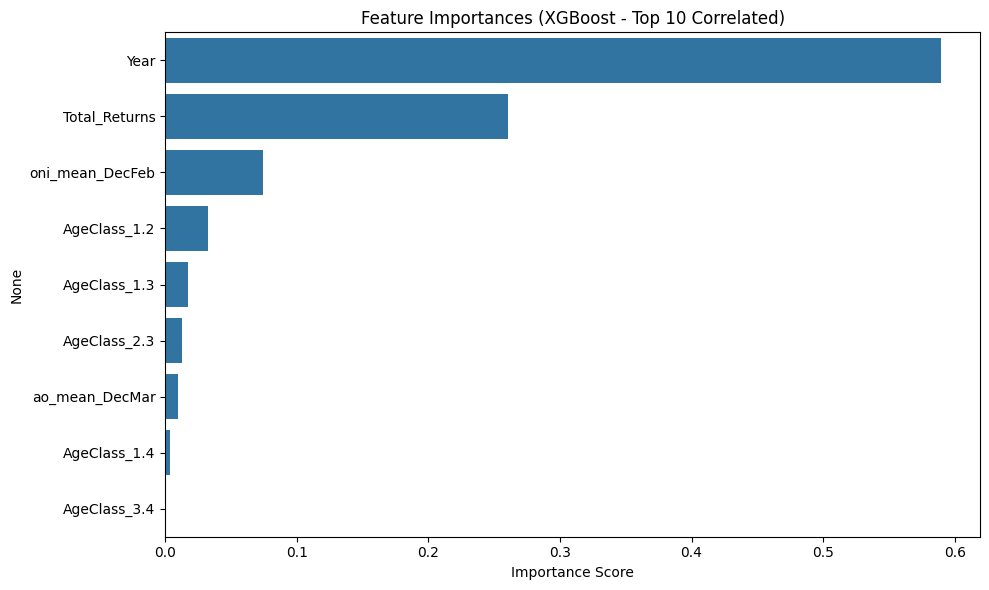

XGBoost Evaluation Metrics (Alagnak, Top 10 Features):
R²   (R-squared):              -0.5278
MSE  (Mean Squared Error):     5324529037171.48
MAPE (Mean Absolute % Error):  35.78%


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# === Step 1: Load and filter data ===
data_set_bristol = pd.read_csv(
    r'C:\Users\MuriloFarias\Desktop\NNS-JULIA\PredictSalmonRuns\murilo_salmon\BristolBay\THIRD_APPROACH\data_set_bristol_encoded.csv'
)

# Keep only rows where River is 'Alagnak'
df_alagnak = data_set_bristol[data_set_bristol['River'] == 'Alagnak'].copy()

# === Step 2: Select top 10 features most correlated with the target ===
correlation = df_alagnak.corr(numeric_only=True)
target_corr = correlation['Total_Returns_NextYear'].drop('Total_Returns_NextYear')
top10_features = target_corr.abs().sort_values(ascending=False).head(9).index.tolist()

# Ensure no duplicate 'Year' column
columns_to_keep = top10_features + ['Total_Returns_NextYear', 'River']
if 'Year' not in top10_features:
    columns_to_keep.append('Year')

df_alagnak = df_alagnak[columns_to_keep]

# === Step 3: Define and apply time-series split ===
def split_time_series_by_river(df, time_column, group_columns, test_fraction=0.2, gap_years=0):
    data_train = pd.DataFrame()
    data_test = pd.DataFrame()

    for _, group_df in df.groupby(group_columns):
        group_df = group_df.sort_values(by=time_column)
        split_idx = int(len(group_df) * (1 - test_fraction))
        train_split = group_df.iloc[:split_idx - gap_years]
        test_split = group_df.iloc[split_idx:]
        data_train = pd.concat([data_train, train_split], axis=0)
        data_test = pd.concat([data_test, test_split], axis=0)

    return data_train.reset_index(drop=True), data_test.reset_index(drop=True)

data_train, data_test = split_time_series_by_river(
    df_alagnak,
    time_column="Year",
    group_columns=["River"],
    test_fraction=0.2,
    gap_years=0
)

# === Step 4: Prepare features and target ===
drop_columns = ['Total_Returns_NextYear', 'River']
if 'Year' not in top10_features:
    drop_columns.append('Year')

X_train = data_train.drop(drop_columns, axis=1)
y_train = data_train['Total_Returns_NextYear']

X_test = data_test.drop(drop_columns, axis=1)
y_test = data_test['Total_Returns_NextYear']

# === Step 5: Train XGBoost Regressor ===
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

# === Step 6: Feature Importances Plot ===
feature_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Feature Importances (XGBoost - Top 10 Correlated)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# === Step 7: Predict & Evaluate ===
y_pred = xgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("XGBoost Evaluation Metrics (Alagnak, Top 10 Features):")
print(f"R²   (R-squared):              {r2:.4f}")
print(f"MSE  (Mean Squared Error):     {mse:.2f}")
print(f"MAPE (Mean Absolute % Error):  {mape:.2f}%")
